<a href="https://colab.research.google.com/github/DevanWestley/TemperaturePrediction/blob/main/PredictTemperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project UTS AI - **Predicting World Temperature Shifts Based on Sea Level Trends with Multiple Linear Regression**


## Anggota Kelompok

Devan Westley - 23/522479/TK/57681

Ega Baskara Nugroho - 23/521518/TK/57532

## Introduction

**WO**: “World Ocean.” This column represents a global measure of sea surface heat content.


**WOse**: The “se” suffix typically stands for “standard error.” Thus, WOse would be the estimated standard error or uncertainty associated with the WO measurement.

**NH**: “Northern Hemisphere.” In this context, it represent sea surface heat content for the northern half of the globe.

**NHse**: Similarly, this column would be the standard error or uncertainty estimate for the Northern Hemisphere measurement.

**SH**: “Southern Hemisphere,” providing the corresponding measurement for that region.


**SHse**: This column would then be the standard error for the Southern Hemisphere measurement.

## Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Predefine Library

In [ ]:
#About Dataset
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['No_Smoothing']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

def _plot_series(df, column, ax):
    ax.plot(df['Year'], df[column], label=column)

#Multiple Linear Regression
def normal_equation(A, b):
    """
    Computes coefficient (x) with normal equation:
    x = (A^T A)^{-1} A^T b
    """
    A_tA = A.T @ A
    A_tb = A.T @ b
    A_tA_inv = np.linalg.inv(A_tA)
    x = A_tA_inv @ A_tb
    return x

#Metrics
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_score(y_true, y_pred):
    """
    Computes the R² (coefficient of determination).
    R² = 1 - (SS_res / SS_tot)
    """
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

#K-Fold Validation\
def k_fold_cross_validation(A, b, k=5):
    n = A.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)  # RNG

    fold_size = n // k
    results = []

    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i < k - 1 else n

        val_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        # Split into training and validation sets
        A_train = A[train_indices]
        b_train = b[train_indices]
        A_val = A[val_indices]
        b_val = b[val_indices]

        coeffs = normal_equation(A_train, b_train)
        b_pred = A_val @ coeffs

        fold_mse = mse(b_val, b_pred)
        fold_r2 = r2_score(b_val, b_pred)

        results.append((fold_mse, fold_r2))
    return results

## About Dataset

In [ ]:
df = pd.read_csv("SeaVSTemp.csv")
df.head()

,Year,No_Smoothing,Lowess(5),WO,WOse,NH,NHse,SH,SHse
0,1957,0.05,-0.04,-9.303,2.025,-3.149,0.925,-6.153,1.100
1,1958,0.06,-0.01,-8.059,2.017,-2.321,0.851,-5.738,1.166
2,1959,0.03,0.01,-8.713,2.036,-2.505,0.824,-6.208,1.212
3,1960,-0.03,0.03,-5.479,1.893,-1.587,0.746,-3.892,1.148
4,1961,0.06,0.01,-4.762,1.773,-1.936,0.711,-2.826,1.061


In [ ]:
print("DataFrame shape (rows, columns):", df.shape)

DataFrame shape (rows, columns): (66, 9)


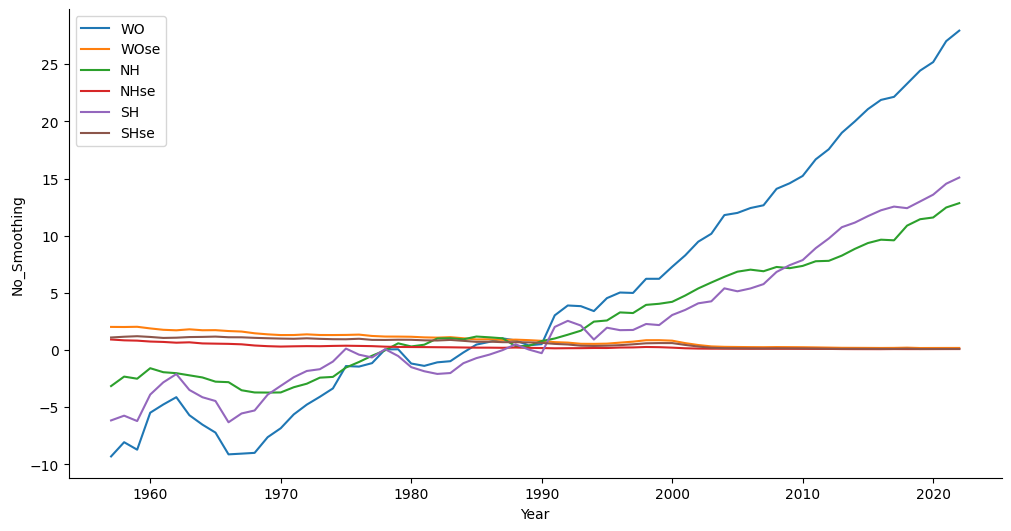

In [ ]:
y_columns = ['WO', 'WOse', 'NH', 'NHse', 'SH', 'SHse']

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Year', ascending=True)

# Plot all series on the same axes
for y in y_columns:
    _plot_series(df_sorted, y, ax)

sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
plt.ylabel('No_Smoothing')
plt.legend()  # Show the legend to differentiate the lines
plt.show()

## Multiple Linear Regression

In [ ]:
A = df[["WO", "WOse", "NH", "NHse", "SH", "SHse"]].values
b = df["No_Smoothing"].values

ones = np.ones((A.shape[0], 1))
oneA = np.hstack((ones, A))  # Augmented with 1s

In [ ]:
coefficients = normal_equation(oneA, b)
equation_str = "Temperature = {:.4f} + {:.4f}*WO + {:.4f}*WOse + {:.4f}*NH + {:.4f}*NHse + {:.4f}*SH + {:.4f}*SHse".format(
coefficients[0], coefficients[1], coefficients[2], coefficients[3], coefficients[4], coefficients[5], coefficients[6])

print("u:")
print(coefficients)
print(equation_str)

u:
[  0.35411021  13.84449359  22.72851528 -13.79293373 -22.71061389
 -13.84648567 -22.95305053]
Temperature = 0.3541 + 13.8445*WO + 22.7285*WOse + -13.7929*NH + -22.7106*NHse + -13.8465*SH + -22.9531*SHse


## Metrics

In [ ]:
y_pred = oneA @ coefficients

mse_value = mse(b, y_pred)
r2_value = r2_score(b, y_pred)

print(f"MSE: {mse_value:.6f}")
print(f"Accuracy (R²): {r2_value*100:.2f}%")

MSE: 0.008397
Accuracy (R²): 92.19%


## K-Fold

Remember the curse of dimentionality, this also determine the success of k-vold validation

In this case, total data is 66, ceil(20%total data) =13

### If k <= 13

In [ ]:
k = 5
cv_results = k_fold_cross_validation(A, b, k=k)

mse_scores = [res[0] for res in cv_results]
r2_scores = [res[1] for res in cv_results]

for i, (m, r2) in enumerate(cv_results):
    print(f"Fold {i+1}: MSE = {m:.4f}, Accuracy (R²) = {r2*100:.2f}%")

print("-----")

# Average MSE across folds
avg_mse = np.mean(mse_scores)
print(f"Average MSE across {k} folds:", avg_mse)

# Average "accuracy" (R²) across folds
avg_r2 = np.mean(r2_scores)
print(f"Average Accuracy (R²) across {k} folds: {avg_r2*100:.2f}%")

Fold 1: MSE = 0.0096, Accuracy (R²) = 87.73%
Fold 2: MSE = 0.0209, Accuracy (R²) = 80.61%
Fold 3: MSE = 0.0094, Accuracy (R²) = 86.90%
Fold 4: MSE = 0.0124, Accuracy (R²) = 83.19%
Fold 5: MSE = 0.0159, Accuracy (R²) = 90.15%
-----
Average MSE across 5 folds: 0.013651577910219061
Average Accuracy (R²) across 5 folds: 85.72%


As we can see it seems that we get normal MSE and Accuracy if we set k is < 20% of its total data

### If k > 13

In [ ]:
k = 25
cv_results = k_fold_cross_validation(A, b, k=k)

mse_scores = [res[0] for res in cv_results]
r2_scores = [res[1] for res in cv_results]

for i, (m, r2) in enumerate(cv_results):
    print(f"Fold {i+1}: MSE = {m:.4f}, Accuracy (R²) = {r2*100:.2f}%")

print("-----")

# Average MSE across folds
avg_mse = np.mean(mse_scores)
print(f"Average MSE across {k} folds:", avg_mse)

# Average "accuracy" (R²) across folds
avg_r2 = np.mean(r2_scores)
print(f"Average Accuracy (R²) across {k} folds: {avg_r2*100:.2f}%")

Fold 1: MSE = 0.0182, Accuracy (R²) = -1039.93%
Fold 2: MSE = 0.0054, Accuracy (R²) = -5264.99%
Fold 3: MSE = 0.0019, Accuracy (R²) = 98.42%
Fold 4: MSE = 0.0259, Accuracy (R²) = -95.76%
Fold 5: MSE = 0.0168, Accuracy (R²) = -4110.58%
Fold 6: MSE = 0.0050, Accuracy (R²) = 95.45%
Fold 7: MSE = 0.0044, Accuracy (R²) = 80.58%
Fold 8: MSE = 0.0049, Accuracy (R²) = 80.97%
Fold 9: MSE = 0.0399, Accuracy (R²) = 9.45%
Fold 10: MSE = 0.0061, Accuracy (R²) = 57.67%
Fold 11: MSE = 0.0308, Accuracy (R²) = 63.36%
Fold 12: MSE = 0.0127, Accuracy (R²) = 18.43%
Fold 13: MSE = 0.0003, Accuracy (R²) = -39.69%
Fold 14: MSE = 0.0067, Accuracy (R²) = 96.74%
Fold 15: MSE = 0.0078, Accuracy (R²) = -213.49%
Fold 16: MSE = 0.0020, Accuracy (R²) = 98.18%
Fold 17: MSE = 0.0096, Accuracy (R²) = 95.56%
Fold 18: MSE = 0.0004, Accuracy (R²) = 99.01%
Fold 19: MSE = 0.0040, Accuracy (R²) = 74.63%
Fold 20: MSE = 0.0015, Accuracy (R²) = -142.66%
Fold 21: MSE = 0.0006, Accuracy (R²) = -162.26%
Fold 22: MSE = 0.0377, Accu

However if we set k > 20% of its total data we might have some issues like this run when some of the fold have negative accuracy which lead to inncorect average accuracy

## Bonus Prediction

In [ ]:
#Linear Regression
predictors = ["WO", "WOse", "NH", "NHse", "SH", "SHse"]
target = "Year"

for predictor in predictors:
    A = df[[predictor]].values
    b = df[target].values

    ones = np.ones((A.shape[0], 1))
    A_aug = np.hstack((ones, A))

    coef = normal_equation(A_aug, b)

    y_pred = A_aug @ coef
    error = mse(b, y_pred)
    r2 = r2_score(b, y_pred)

    print(f"{target} = {coef[0]:.4f} + {coef[1]:.4f}*{predictor}")
    print(f"MSE: {error:.6f}")
    print(f"Accuracy (R²): {r2:.6f}\n")

Year = 1981.2028 + 1.7582*WO
MSE: 25.506435
Accuracy (R²): 0.929718

Year = 2018.4080 + -32.2607*WOse
MSE: 17.058051
Accuracy (R²): 0.952997

Year = 1979.4927 + 3.8790*NH
MSE: 25.510119
Accuracy (R²): 0.929708

Year = 2011.6518 + -79.4663*NHse
MSE: 86.498004
Accuracy (R²): 0.761659

Year = 1982.8191 + 3.1230*SH
MSE: 35.247300
Accuracy (R²): 0.902878

Year = 2018.8201 + -47.5052*SHse
MSE: 18.885193
Accuracy (R²): 0.947963



Because of the low accuracy for NHse we try to change from linear regression to quadratic regression.

In [ ]:
year = 2026

# Model Coefficients
models = {
    'WO':     {'intercept': 1981.2028, 'coef': 1.7582},
    'WOse':   {'intercept': 2018.4080, 'coef': -32.2607},
    'NH':     {'intercept': 1979.4927, 'coef': 3.8790},
    'NHse':   {'intercept': 2011.6518, 'coef': -79.4663},
    'SH':     {'intercept': 1982.8191, 'coef': 3.1230},
    'SHse':   {'intercept': 2018.8201, 'coef': -47.5052},
}

# Compute variable values
v_values = [(year - m['intercept']) / m['coef'] for m in models.values()]
v = np.array([1] + v_values).reshape(-1, 1)  # Column vector

# Compute Temperature Shift
uvT = -np.dot(coefficients, v)

print("v (column vector):\n", v)
print("u (row vector):\n", coefficients)
print("Temperature Shift =\n", uvT)



v (column vector):
 [[ 1.        ]
 [25.47901263]
 [-0.23533277]
 [11.98950761]
 [-0.18055704]
 [13.82673711]
 [-0.15113924]]
u (row vector):
 [  0.35411021  13.84449359  22.72851528 -13.79293373 -22.71061389
 -13.84648567 -22.95305053]
Temperature Shift =
 [1.50316052]


So, the world temperature in 2026 will increase by 1.503 degree of Celcius from previous year.